# Movie Data ETL Pipeline - Transform

This notebook will continue the transform step of the pipeline by merging the Wikipedia data and the Kaggle data. Some additional cleaning and transformations will have to be done on the combined data before it is ready to be loaded into a SQL database.

### Dependencies and data

In [21]:
# Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# Plot settings
plot_styles = mpl.style.available
mpl.style.use(plot_styles[0])
mpl.rcParams['figure.figsize'] = (12, 4)
mpl.rcParams['font.size'] = 15

In [4]:
# Path to data directory
data_path = os.path.join('..', 'data')

# Paths to data files
wmovies_path = os.path.join(data_path, 'wiki_movies.pkl')
kmovies_path = os.path.join(data_path, 'kaggle_movies.pkl')
print(wmovies_path)
print(kmovies_path)

../data/wiki_movies.pkl
../data/kaggle_movies.pkl


In [5]:
# Clean Wikipedia movie data
wmovies_df = pd.read_pickle(wmovies_path)
wmovies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6894 entries, 0 to 6935
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   box_office            5449 non-null   float64       
 1   budget                4712 non-null   float64       
 2   cinematographers      6249 non-null   object        
 3   country               6674 non-null   object        
 4   director              6894 non-null   object        
 5   distributor           6591 non-null   object        
 6   editors               6409 non-null   object        
 7   languages             6823 non-null   object        
 8   composers             6427 non-null   object        
 9   producers             6720 non-null   object        
 10  production_companies  5297 non-null   object        
 11  release_date          6869 non-null   datetime64[ns]
 12  duration              6892 non-null   float64       
 13  writers           

In [6]:
# Clean Kaggle movie data
kmovies_df = pd.read_pickle(kmovies_path)
kmovies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45408 entries, 0 to 45465
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                45408 non-null  int64         
 1   genres                45408 non-null  object        
 2   id                    45408 non-null  int64         
 3   imdb_id               45407 non-null  object        
 4   original_language     45397 non-null  object        
 5   overview              44456 non-null  object        
 6   popularity            45405 non-null  float64       
 7   poster_path           45027 non-null  object        
 8   production_companies  45405 non-null  object        
 9   production_countries  45405 non-null  object        
 10  release_date          45325 non-null  datetime64[ns]
 11  revenue               45405 non-null  float64       
 12  runtime               45150 non-null  float64       
 13  spoken_languages

### Join movie data from both sources

In [7]:
# Merge data
movies_df = pd.merge(wmovies_df, kmovies_df, how='inner', on='imdb_id', suffixes=['_wiki', '_kaggle'])
movies_df.head(2)

,box_office,budget_wiki,cinematographers,country,director,distributor,editors,languages,composers,producers,...,production_companies_kaggle,production_countries,release_date_kaggle,revenue,runtime,spoken_languages,status,title_kaggle,vote_average,vote_count
0,21400000.0,20000000.0,Oliver Wood,United States,Renny Harlin,20th Century Fox,Michael Tronick,English,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",...,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1990-07-11,20423389.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Adventures of Ford Fairlane,6.2,72.0
1,2700000.0,6000000.0,Mark Plummer,United States,James Foley,Avenue Pictures,Howard E. Smith,English,Maurice Jarre,"[Ric Kidney, Robert Redlin]",...,"[{'name': 'Avenue Pictures Productions', 'id':...","[{'iso_3166_1': 'US', 'name': 'United States o...",1990-08-24,0.0,114.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"After Dark, My Sweet",6.5,17.0


### Find redundant columns

Since the 2 dataframes being joined contain similar data, they will have several of the same columns. For these columns, it would be redundant to keep both, so we will examine each pair to see what is the best course of action to take. In most cases, we will likely just keep the one with more consistent data. A table will be created to keep track of the action we take on each pair.

In [6]:
# List cols
movies_df.columns.sort_values()

Index(['box_office', 'budget_kaggle', 'budget_wiki', 'cinematographers',
       'composers', 'country', 'director', 'distributor', 'duration',
       'editors', 'genres', 'id', 'imdb_id', 'imdb_link', 'languages',
       'original_language', 'overview', 'popularity', 'poster_path',
       'producers', 'production_companies_kaggle', 'production_companies_wiki',
       'production_countries', 'release_date_kaggle', 'release_date_wiki',
       'revenue', 'runtime', 'spoken_languages', 'stars', 'status',
       'title_kaggle', 'title_wiki', 'url', 'vote_average', 'vote_count',
       'writers', 'year'],
      dtype='object')

In [8]:
# List of redundant col name pairs (wikipedia col, kaggle col)
redundant_cols = [
    ('box_office', 'revenue'),
    ('budget_wiki', 'budget_kaggle'),
    ('duration', 'runtime'),
    ('languages', 'original_language'),
    ('production_companies_wiki', 'production_companies_kaggle'),
    ('release_date_wiki', 'release_date_kaggle'),
    ('title_wiki', 'title_kaggle')
]

# Create a table to keep track of the action taken for each pair
redundant_cols = pd.DataFrame(redundant_cols, columns=['wikipedia', 'kaggle'])
redundant_cols['action'] = ''
redundant_cols

,wikipedia,kaggle,action
0,box_office,revenue,
1,budget_wiki,budget_kaggle,
2,duration,runtime,
3,languages,original_language,
4,production_companies_wiki,production_companies_kaggle,
5,release_date_wiki,release_date_kaggle,
6,title_wiki,title_kaggle,


### Inspect title columns

In [9]:
# Extract title cols
title = movies_df[['title_wiki', 'title_kaggle']]

# Rows where titles are different between the 2 cols
print(title.query('title_wiki != title_kaggle').shape[0])
title.query('title_wiki != title_kaggle').head(4)

429


,title_wiki,title_kaggle
27,China Cry,China Cry: A True Story
36,Daddy's Dyin' ...Who's Got the Will?,Daddy's Dyin'... Who's Got the Will?
41,Delta Force 2,Delta Force 2: The Colombian Connection
47,DuckTales the Movie:Treasure of the Lost Lamp,DuckTales: The Movie - Treasure of the Lost Lamp


It looks like the Kaggle data has more complete `title`s. If it contains no missing `title`s, or at least less than the Wikipedia data, then we will drop the Wikipedia `title`s and keep the Kaggle `title`s.

In [10]:
# Check for null titles in the Kaggle col
title[(title['title_kaggle'] == '') | (title['title_kaggle'].isnull())].shape[0]

0

In [11]:
# Add action for title - drop the Wikipedia column
redundant_cols.loc[6, 'action'] = 'drop wiki col'
redundant_cols

,wikipedia,kaggle,action
0,box_office,revenue,
1,budget_wiki,budget_kaggle,
2,duration,runtime,
3,languages,original_language,
4,production_companies_wiki,production_companies_kaggle,
5,release_date_wiki,release_date_kaggle,
6,title_wiki,title_kaggle,drop wiki col


### Inspect language columns

In [16]:
# Extract language cols
lang = movies_df[['languages', 'original_language']]

# Rows where languages are different between the 2 cols
print(lang.query('languages != original_language').shape[0])
lang.query('languages != original_language').head(4)

5983


,languages,original_language
0,English,en
1,English,en
2,"[English, Lao]",en
3,English,en


The Wikipedia `languages` column contains lists, so it would be easier to keep Kaggle's `original_language` column, assuming there are no missing or strange values.

In [12]:
# Check for null languages the Kaggle col
print(lang[(lang['original_language'] == '') | (lang['original_language'].isnull())].shape[0])

# Check Kaggle column vals
lang['original_language'].unique()

0


array(['en', 'de', 'es', 'fr', 'it', 'zh', 'sv', 'ja', 'da', 'pt', 'hi',
       'ko', 'ab', 'tr', 'he', 'ar', 'cn', 'ru'], dtype=object)

In [13]:
# Add action for language - drop the Wikipedia col
redundant_cols.loc[3, 'action'] = 'drop wiki col'
redundant_cols

,wikipedia,kaggle,action
0,box_office,revenue,
1,budget_wiki,budget_kaggle,
2,duration,runtime,
3,languages,original_language,drop wiki col
4,production_companies_wiki,production_companies_kaggle,
5,release_date_wiki,release_date_kaggle,
6,title_wiki,title_kaggle,drop wiki col


### Inspect production company columns

In [14]:
# Extract production company cols
production = movies_df[['production_companies_wiki', 'production_companies_kaggle']]

# Rows where values are different between the 2 cols
print(production.query('production_companies_wiki != production_companies_kaggle').shape[0])
production.query('production_companies_wiki != production_companies_kaggle').head(4)

5983


,production_companies_wiki,production_companies_kaggle
0,Silver Pictures,[{'name': 'Twentieth Century Fox Film Corporat...
1,Avenue Pictures,"[{'name': 'Avenue Pictures Productions', 'id':..."
2,"[Carolco Pictures, IndieProd Company]","[{'name': 'IndieProd Company Productions', 'id..."
3,NaN,"[{'name': 'Orion Pictures', 'id': 41}]"


In [19]:
# Check for null vals in the Kaggle col
print(production[(production['production_companies_kaggle'] == '') | 
                 (production['production_companies_kaggle'].isnull())].shape[0])

# Check Kaggle col vals
production['production_companies_kaggle'].unique()[:4]

0


array(["[{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}, {'name': 'Silver Pictures', 'id': 1885}]",
       "[{'name': 'Avenue Pictures Productions', 'id': 251}]",
       "[{'name': 'IndieProd Company Productions', 'id': 959}, {'name': 'Carolco Pictures', 'id': 14723}]",
       "[{'name': 'Orion Pictures', 'id': 41}]"], dtype=object)

We will be keeping the Kaggle column because it's more descriptive than the Wikipedia values.

In [20]:
# Add action to production company - drop the Wikipedia column
redundant_cols.loc[4, 'action'] = 'drop wiki col'
redundant_cols

,wikipedia,kaggle,action
0,box_office,revenue,
1,budget_wiki,budget_kaggle,
2,duration,runtime,
3,languages,original_language,drop wiki col
4,production_companies_wiki,production_companies_kaggle,drop wiki col
5,release_date_wiki,release_date_kaggle,
6,title_wiki,title_kaggle,drop wiki col


### Inspect budget columns

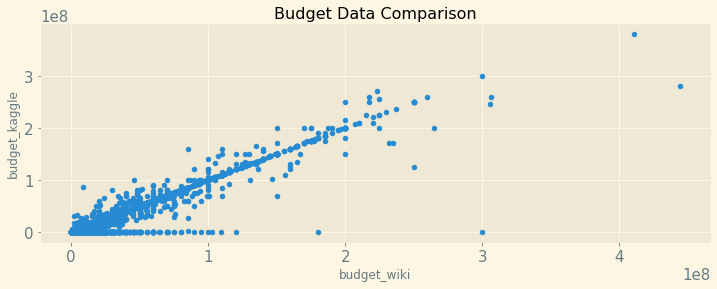

In [42]:
# Extract budget cols
budget = movies_df[['budget_wiki', 'budget_kaggle']]

# Scatterplot
budget.plot(kind='scatter', x='budget_wiki', y='budget_kaggle', title='Budget Data Comparison')
plt.show()

In [32]:
# Num of 0 vals
print('Number of 0s in Wikipedia `budget`:', (budget['budget_wiki'] == 0).sum())
print('Number of 0s in Kaggle `budget`:', (budget['budget_kaggle'] == 0).sum())

# Check null vals
budget.isnull().sum()

Number of 0s in Wikipedia `budget`: 0
Number of 0s in Kaggle `budget`: 2350


budget_wiki      1589
budget_kaggle       0
dtype: int64

The Wikipedia data has 1589 missing `budget` values, but the Kaggle data has 2350 `budget` values of 0, which are probably missing values. We will use `budget_kaggle` to fill any missing `budget_wiki` and then drop `budget_kaggle`.

In [33]:
# Add action to budget - fill Wikipedia's missing vals with Kaggle's budget vals, then drop the Kaggle col
redundant_cols.loc[1, 'action'] = 'fill wiki missing, drop kaggle col'
redundant_cols

,wikipedia,kaggle,action
0,box_office,revenue,
1,budget_wiki,budget_kaggle,"fill wiki missing, drop kaggle col"
2,duration,runtime,
3,languages,original_language,drop wiki col
4,production_companies_wiki,production_companies_kaggle,drop wiki col
5,release_date_wiki,release_date_kaggle,
6,title_wiki,title_kaggle,drop wiki col


### Inspect revenue columns

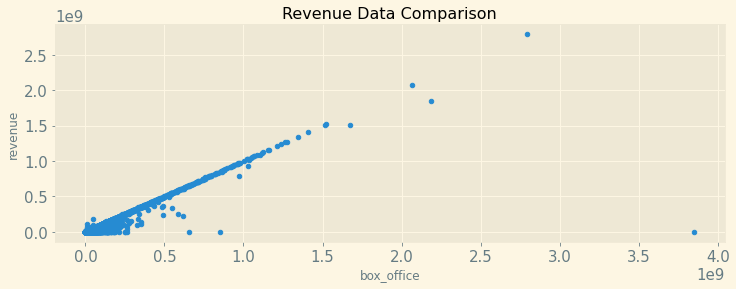

In [43]:
# Extract budget cols
revenue = movies_df[['box_office', 'revenue']]

# Scatterplot
revenue.plot(kind='scatter', x='box_office', y='revenue', title='Revenue Data Comparison')
plt.show()

In [35]:
# Number of 0 vals
print('Number of 0s in Wikipedia `box_office`:', (revenue['box_office'] == 0).sum())
print('Number of 0s in Kaggle `revenue`:', (revenue['revenue'] == 0).sum())

# Check null vals
revenue.isnull().sum()

Number of 0s in Wikipedia `box_office`: 0
Number of 0s in Kaggle `revenue`: 2326


box_office    898
revenue         0
dtype: int64

This is the same case as `budget` so we will take the same action for `revenue`.

In [36]:
# Add action to revenue - same as budget
redundant_cols.loc[0, 'action'] = 'fill wiki missing, drop kaggle col'
redundant_cols

,wikipedia,kaggle,action
0,box_office,revenue,"fill wiki missing, drop kaggle col"
1,budget_wiki,budget_kaggle,"fill wiki missing, drop kaggle col"
2,duration,runtime,
3,languages,original_language,drop wiki col
4,production_companies_wiki,production_companies_kaggle,drop wiki col
5,release_date_wiki,release_date_kaggle,
6,title_wiki,title_kaggle,drop wiki col


### Inspect runtime columns

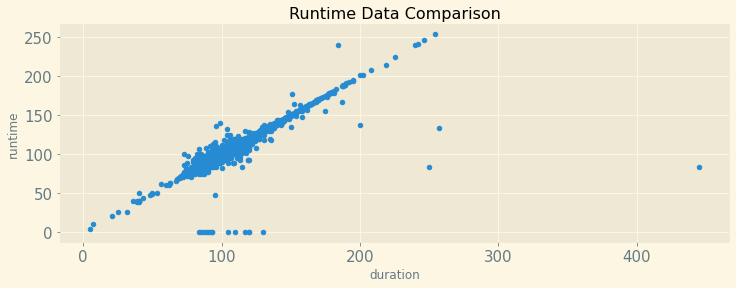

In [44]:
# Extract budget cols
run = movies_df[['duration', 'runtime']]

# Scatterplot
run.plot(kind='scatter', x='duration', y='runtime', title='Runtime Data Comparison')
plt.show()

In [38]:
# Number of 0 vals
print('Number of 0s in Wikipedia `duration`:', (run['duration'] == 0).sum())
print('Number of 0s in Kaggle `runtime`:', (run['runtime'] == 0).sum())

# Check null vals
run.isnull().sum()

Number of 0s in Wikipedia `duration`: 0
Number of 0s in Kaggle `runtime`: 14


duration    2
runtime     0
dtype: int64

Even though the Wikipedia data (`duration`) contains less missing/0 values, it has some extreme outliers, so we will actually use it to fill in the Kaggle data's (`runtime`) zero values and then drop it (drop `duration`).

In [39]:
# Add action to runtime - fill the zero vals in the Kaggle col, then drop the Wikipedia col
redundant_cols.loc[2, 'action'] = 'fill kaggle missing, drop wiki col'
redundant_cols

,wikipedia,kaggle,action
0,box_office,revenue,"fill wiki missing, drop kaggle col"
1,budget_wiki,budget_kaggle,"fill wiki missing, drop kaggle col"
2,duration,runtime,"fill kaggle missing, drop wiki col"
3,languages,original_language,drop wiki col
4,production_companies_wiki,production_companies_kaggle,drop wiki col
5,release_date_wiki,release_date_kaggle,
6,title_wiki,title_kaggle,drop wiki col


### Inspect release date column

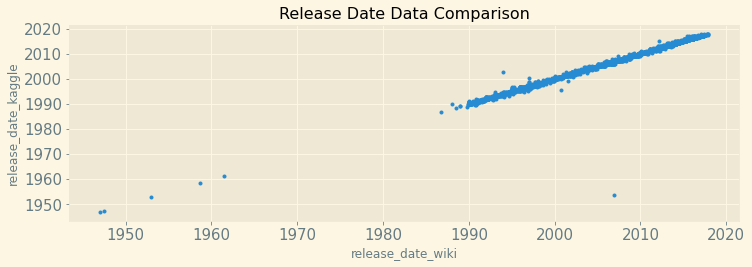

In [45]:
# Extract budget cols
release = movies_df[['release_date_wiki', 'release_date_kaggle']]

# Scatterplot
release.plot(x='release_date_wiki', y='release_date_kaggle', style='.', 
             legend=False, ylabel='release_date_kaggle', title='Release Date Data Comparison')
plt.xticks(rotation=0, ha='center')
plt.show()

There is a strange outlier with a `release_date` before 1960 in the Kaggle data but after 2000 in the Wikipedia data. Let's inspect this movie.

In [46]:
# Inspect outlier
release_date_cols = ['title_wiki', 'title_kaggle', 'release_date_wiki', 'release_date_kaggle']
release_outlier = movies_df.loc[(movies_df['release_date_wiki'] > '2000') & 
                                (movies_df['release_date_kaggle'] < '1960'), release_date_cols]
release_outlier

,title_wiki,title_kaggle,release_date_wiki,release_date_kaggle
3586,The Holiday,From Here to Eternity,2006-12-08,1953-08-28


In [29]:
# Check null vals
release.isnull().sum()

release_date_wiki      8
release_date_kaggle    0
dtype: int64

It looks like 2 different movies shared an `imdb_id` so they were merged together. We will be dropping this single movie and the Wikipedia `release_date` since it has some missing values.

In [47]:
# Add action to release date - drop outlier and drop the Wikipedia col
redundant_cols.loc[5, 'action'] = 'drop outlier, drop wiki col'
redundant_cols

,wikipedia,kaggle,action
0,box_office,revenue,"fill wiki missing, drop kaggle col"
1,budget_wiki,budget_kaggle,"fill wiki missing, drop kaggle col"
2,duration,runtime,"fill kaggle missing, drop wiki col"
3,languages,original_language,drop wiki col
4,production_companies_wiki,production_companies_kaggle,drop wiki col
5,release_date_wiki,release_date_kaggle,"drop outlier, drop wiki col"
6,title_wiki,title_kaggle,drop wiki col


### Drop redundant columns

With a plan defined for each pair of redundant columns in the table above, we will now be executing these actions.

In [48]:
# Drop `title_wiki`, `languages`, and `production_companies_wiki`
movies_df.drop(['title_wiki', 'languages', 'production_companies_wiki'], axis=1, inplace=True)

# Drop the `release_date` outlier then drop `release_date_wiki`
movies_df.drop(release_outlier.index, inplace=True)
movies_df.drop('release_date_wiki', axis=1, inplace=True)
movies_df.shape

(5982, 33)

In [32]:
def filla_dropb(cola, colb, data):
    
    """ Fill missing values in column a (keep) using values in column b (drop), 
    then drop column b """
    
    # Copy df
    df = data.copy()
    
    def filla(row):
        cond1 = pd.isnull(row[cola]) or row[cola] == 0
        cond2 = pd.notnull(row[colb]) and row[colb] != 0
        return row[colb] if cond1 and cond2 else row[cola]
            
    df[cola] = df.apply(filla, axis=1)
    return df.drop(colb, axis=1)
    

# Fill `budget`, `revenue`, and `runtime` missing values, then drop `Budget`, `Box office`, `Duration`
movies_df = filla_dropb('box_office', 'revenue', data=movies_df)
movies_df = filla_dropb('budget_wiki', 'budget_kaggle', data=movies_df)
movies_df = filla_dropb('runtime', 'duration', data=movies_df)
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5982
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   box_office                   5149 non-null   float64       
 1   budget_wiki                  4600 non-null   float64       
 2   cinematographers             5519 non-null   object        
 3   country                      5819 non-null   object        
 4   director                     5982 non-null   object        
 5   distributor                  5824 non-null   object        
 6   editors                      5657 non-null   object        
 7   composers                    5663 non-null   object        
 8   producers                    5878 non-null   object        
 9   writers                      5854 non-null   object        
 10  stars                        5877 non-null   object        
 11  imdb_link                    5982 non-null 

### Rename and reorder columns

In [33]:
# List columns
movies_df.columns

Index(['box_office', 'budget_wiki', 'cinematographers', 'country', 'director',
       'distributor', 'editors', 'composers', 'producers', 'writers', 'stars',
       'imdb_link', 'url', 'year', 'imdb_id', 'genres', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies_kaggle', 'production_countries',
       'release_date_kaggle', 'runtime', 'spoken_languages', 'status',
       'title_kaggle', 'vote_average', 'vote_count'],
      dtype='object')

In [34]:
# Column order
col_order = ['id', 'imdb_id', 'imdb_link', 'url', 'poster_path', 'title_kaggle', 'overview',
             'release_date_kaggle', 'year', 'runtime', 'budget_wiki', 'box_office', 
             'genres', 'country', 'original_language', 'spoken_languages',
             'status', 'popularity', 'vote_average', 'vote_count', 
             'producers', 'writers', 'director', 'cinematographers', 'editors', 'composers', 'stars',
             'production_companies_kaggle', 'production_countries', 'distributor']

# New column names
col_names = ['movie_id', 'imdb_id', 'imdb_link', 'url', 'poster_path', 'title', 'overview',
             'release_date', 'year', 'runtime', 'budget', 'revenue', 
             'genres', 'country', 'language', 'spoken_languages',
             'status', 'popularity', 'vote_average', 'vote_count', 
             'producers', 'writers', 'director', 'cinematographers', 'editors', 'composers', 'stars',
             'production_companies', 'production_countries', 'distributor']

# Rename and order columns
movies_df = movies_df.rename({old: new for old, new in zip(col_order, col_names)}, axis=1)
movies_df = movies_df[col_names]
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5982
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movie_id              5982 non-null   int64         
 1   imdb_id               5982 non-null   object        
 2   imdb_link             5982 non-null   object        
 3   url                   5982 non-null   object        
 4   poster_path           5981 non-null   object        
 5   title                 5982 non-null   object        
 6   overview              5977 non-null   object        
 7   release_date          5982 non-null   datetime64[ns]
 8   year                  5982 non-null   int64         
 9   runtime               5982 non-null   float64       
 10  budget                4600 non-null   float64       
 11  revenue               5149 non-null   float64       
 12  genres                5982 non-null   object        
 13  country           

### Save movie data

In [35]:
# Save data
movies_df.to_pickle(data_path + 'movies.pkl')
pd.read_pickle(data_path + 'movies.pkl').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5982
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movie_id              5982 non-null   int64         
 1   imdb_id               5982 non-null   object        
 2   imdb_link             5982 non-null   object        
 3   url                   5982 non-null   object        
 4   poster_path           5981 non-null   object        
 5   title                 5982 non-null   object        
 6   overview              5977 non-null   object        
 7   release_date          5982 non-null   datetime64[ns]
 8   year                  5982 non-null   int64         
 9   runtime               5982 non-null   float64       
 10  budget                4600 non-null   float64       
 11  revenue               5149 non-null   float64       
 12  genres                5982 non-null   object        
 13  country           